# DPA Contest v4

## Load traces

In [1]:
import pandas
import pprint

FORMAT_OFFSETS = 'Offsets'
FORMAT_SIZES = 'Sizes in bytes'
FORMAT_STRUCT = 'Struct'

dpacv4_format = pandas.read_csv('dpacv4_format.csv', index_col=0)
pprint.pprint(dpacv4_format)

                   Offsets  Sizes in bytes Struct
Names                                            
DESCRIPTOR_NAME          0              16    16s
TEMPLATE_NAME           16              16    16s
COMM_TYPE               32               2      h
COMM_ORDER              34               2      h
WAVE_DESCRIPTOR         36               4      L
USER_TEXT               40               4      L
RES_DESC1               44               4      L
TRIGTIME_ARRAY          48               4      L
RIS_TIME_ARRAY          52               4      L
RES_ARRAY_1             56               4      L
WAVE_ARRAY_1            60               4      L
WAVE_ARRAY_2            64               4      L
INSTRUMENT_NAME         76              40    40s
WAVE_ARRAY_COUNT       116               4      L
FIRST_VALID_POINT      124               4      L
LAST_VALID_POINT       128               4      L
VERTICAL_GAIN          156               4      f
VERTICAL_OFFSET        160               4      f


In [2]:
dpacv4_format.loc['COMM_ORDER']

Offsets           34
Sizes in bytes     2
Struct             h
Name: COMM_ORDER, dtype: object

In [3]:
import pprint
import glob

#
# define root directory of all traces (*.bz2) which should be
# downloaded from http://www.dpacontest.org/v4/42_traces.php and 
# uncompressed in bz2_trace_directory
#
bz2_trace_directory = "../dpacv4_data/"
# get file names of all traces
bz2_files = [f for f in glob.glob(bz2_trace_directory + "**/*.bz2", recursive=True)]
bz2_files = sorted(bz2_files)
pprint.pprint("number of trace files = %d" % len(bz2_files))

'number of trace files = 5000'


In [4]:
import bz2
import struct
import numpy

DPACV4_OFFSET = 11

def decode_trace(binary_data):
    comm_order_series = dpacv4_format.loc['COMM_ORDER']
    comm_order = struct.unpack('>%s' % comm_order_series[FORMAT_STRUCT],
                               binary_data[comm_order_series[FORMAT_OFFSETS] : comm_order_series[FORMAT_OFFSETS]+comm_order_series[FORMAT_SIZES]])[0],
    if 0 == comm_order:
        byteorder = '>'
    else:
        byteorder = '<'
    header = {}
    for name in dpacv4_format.index:
        series = dpacv4_format.loc[name]
        header[name] = struct.unpack('%s%s' % (byteorder, series[FORMAT_STRUCT]),
                                     binary_data[series[FORMAT_OFFSETS] : series[FORMAT_OFFSETS]+series[FORMAT_SIZES]])[0]
    data = binary_data[header['WAVE_DESCRIPTOR'] + 1: ]
    pprint.pprint('unpack data length = %d' % len(data))
    if 0 == header['COMM_TYPE']:
        iter_unpack = struct.iter_unpack('%sb' % byteorder, data)
    else:
        iter_unpack = struct.iter_unpack('%sh' % byteorder, data)
    trace = numpy.asarray([x[0] for x in iter_unpack])
        
    assert(len(trace) == header['WAVE_ARRAY_COUNT'])
    return header, trace

HEADER = 'header'
FILENAME = 'filename'
TRACE = 'trace'

def load_trace_file(filename):    
    pprint.pprint('bz2_files = %s' % filename)
    with bz2.BZ2File(filename=filename, mode='r') as fd:
        raw_data = fd.read()
    pprint.pprint(len(raw_data))
    trace_header, trace_data = decode_trace(raw_data[DPACV4_OFFSET:])
    return {FILENAME:filename, HEADER: trace_header, TRACE: trace_data}

In [5]:
# extract data files
trace_indexes = [2, 3, 15, 27, 37, 43, 48]

trace_data = [load_trace_file(bz2_files[idx]) for idx in trace_indexes]
for data in trace_data:
    pprint.pprint('********* %s' % data[FILENAME])
    pprint.pprint(data[HEADER])
    pprint.pprint('data length = %d' % len(data[TRACE]))

'bz2_files = ../dpacv4_data/k00/DPACV42_000002.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000003.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000015.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000027.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000037.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000043.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000048.trc.bz2'
1704760
'unpack data length = 1704402'
'********* ../dpacv4_data/k00/DPACV42_000002.trc.bz2'
{'COMM_ORDER': 1,
 'COMM_TYPE': 0,
 'DESCRIPTOR_NAME': b'WAVEDESC\x00\x00\x00\x00\x00\x00\x00\x00',
 'FIRST_VALID_POINT': 0,
 'INSTRUMENT_NAME': b'LECROYWR6100A\x00\x00\x00EH\x00\x00\x00\x00\x00\x00'
                    b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
         

## Load Index

The index file should be downloaded from http://www.dpacontest.org/v4/traces/v4_2/dpav4_2_index
and save the the defined directory __bz2_trace_directory__
- 1st column: the AES-128 key (128 bits represented as 32 hexadecimal digits)
- 2nd column: the plaintext (128 bits represented as 32 hexadecimal digits)
- 3rd column: the ciphertext (128 bits represented as 32 hexadecimal digits)
- 4th column: the Shuffle0 permutation (see the algorithm specifications, 16 x 1 hexadecimal digit)
- 5th column: the Shuffle10 permutation (see the algorithm specifications, 16 x 1 hexadecimal digit)
- 6th column: the offsets (see the algorithm specifications, 16 x 1 hexadecimal digit)
- 7th column: the name of the directory (below the top-level directory DPA_contestv4_2) where the trace is stored
- 8th column: the name of the trace

In [6]:
import os
index_filename = os.path.join(bz2_trace_directory, 'dpav4_2_index')
dpav42_index = pandas.read_csv(index_filename, header=None, sep=' ')

column_names = ["AES-128 key",
                "plaintext",
                "ciphertext",
                "Shuffle0",
                "Shuffle10",
                "offsets",
                "name of directory",
                "name of trace"]
dpav42_index.columns = column_names
dpav42_index

,AES-128 key,plaintext,ciphertext,Shuffle0,Shuffle10,offsets,name of directory,name of trace
0,8249CEB658C71D41D7B734449629AB97,73136C16F1E0CE864A2A2C6C8400CF01,BDAA8B4BE13E13CD5250685B67443F84,AB5D4F761C28E039,1A9406F3B2857CED,05C229626F9D8B39,k00,DPACV42_000000.trc.bz2
1,8249CEB658C71D41D7B734449629AB97,859659A916F6357DB36CE94D1F2ED27D,2D3A189063156D96BE8CCD136ECD0AA7,0CA58F61B749ED32,E4870FADC296B153,AA9CCC22847BC9FF,k00,DPACV42_000001.trc.bz2
2,8249CEB658C71D41D7B734449629AB97,F23EAE14838052E4F65588F2BBC7A149,B9631443715B2D6C361D71B2E0E58063,9D21F6508A7CEB43,5910A68BC73D24FE,A19E8ECC588C2D60,k00,DPACV42_000002.trc.bz2
3,8249CEB658C71D41D7B734449629AB97,31F5388B7A57DD05265D95DD5EC7D64F,100DCAB37256123732E7A43965E3E278,EA5CFBD349072168,E86FCB3219D40A75,F37849B9AB801A04,k00,DPACV42_000003.trc.bz2
4,8249CEB658C71D41D7B734449629AB97,25F43D42C36FE7D8E74D881D828F98FD,3B3C7B86AE4E875D4E4AFF2DA77C72CB,74EF2C503B198DA6,25E61CFD308479BA,267B52BA1616C520,k00,DPACV42_000004.trc.bz2
...,...,...,...,...,...,...,...,...
79995,B3E0A2B88E2DCF4BF765F2AAD1538588,8DA06ABB79F8430B66CBE1A7F8802BBB,3C351D286B36CCF68363F15F0497E421,0E8357F1D96B24CA,5B97603CAE2D81F4,04477DA2F4705F2E,k15,DPACV42_079995.trc.bz2
79996,B3E0A2B88E2DCF4BF765F2AAD1538588,6E4FD310E7ECE302738EDB0A4068D1B7,F8E97238CB8CAAAD80264766CAC6684A,EB30CF758D1A4296,B139C7D6E5AF0428,0120E0F85278CB33,k15,DPACV42_079996.trc.bz2
79997,B3E0A2B88E2DCF4BF765F2AAD1538588,B969B0C409E25ABC4DACFA2D448424ED,AFD8711A7CB02F119B55561412EC7EEA,6475218FEBD9C30A,59D1BF038462E7CA,D74583F858C7441C,k15,DPACV42_079997.trc.bz2
79998,B3E0A2B88E2DCF4BF765F2AAD1538588,FC46F5053F4ABE08DD1C43F2089CB2AA,34EC4FDDE733BAA3F16ADCCEB8005F0A,8E5F6A47913BDC02,178BA6F05D294EC3,2966E941D61E9544,k15,DPACV42_079998.trc.bz2


In [7]:
DPA_INDEX = 'dpa_index'
for data in trace_data:
    os.path.basename(data[FILENAME])
    s = dpav42_index[dpav42_index[column_names[7]] == os.path.basename(data[FILENAME])]
    assert(s.shape[0] == 1)
    data[DPA_INDEX] = s.iloc[0]

## Visualizations

### Visualizations the raw traces

<IPython.core.display.Javascript object>


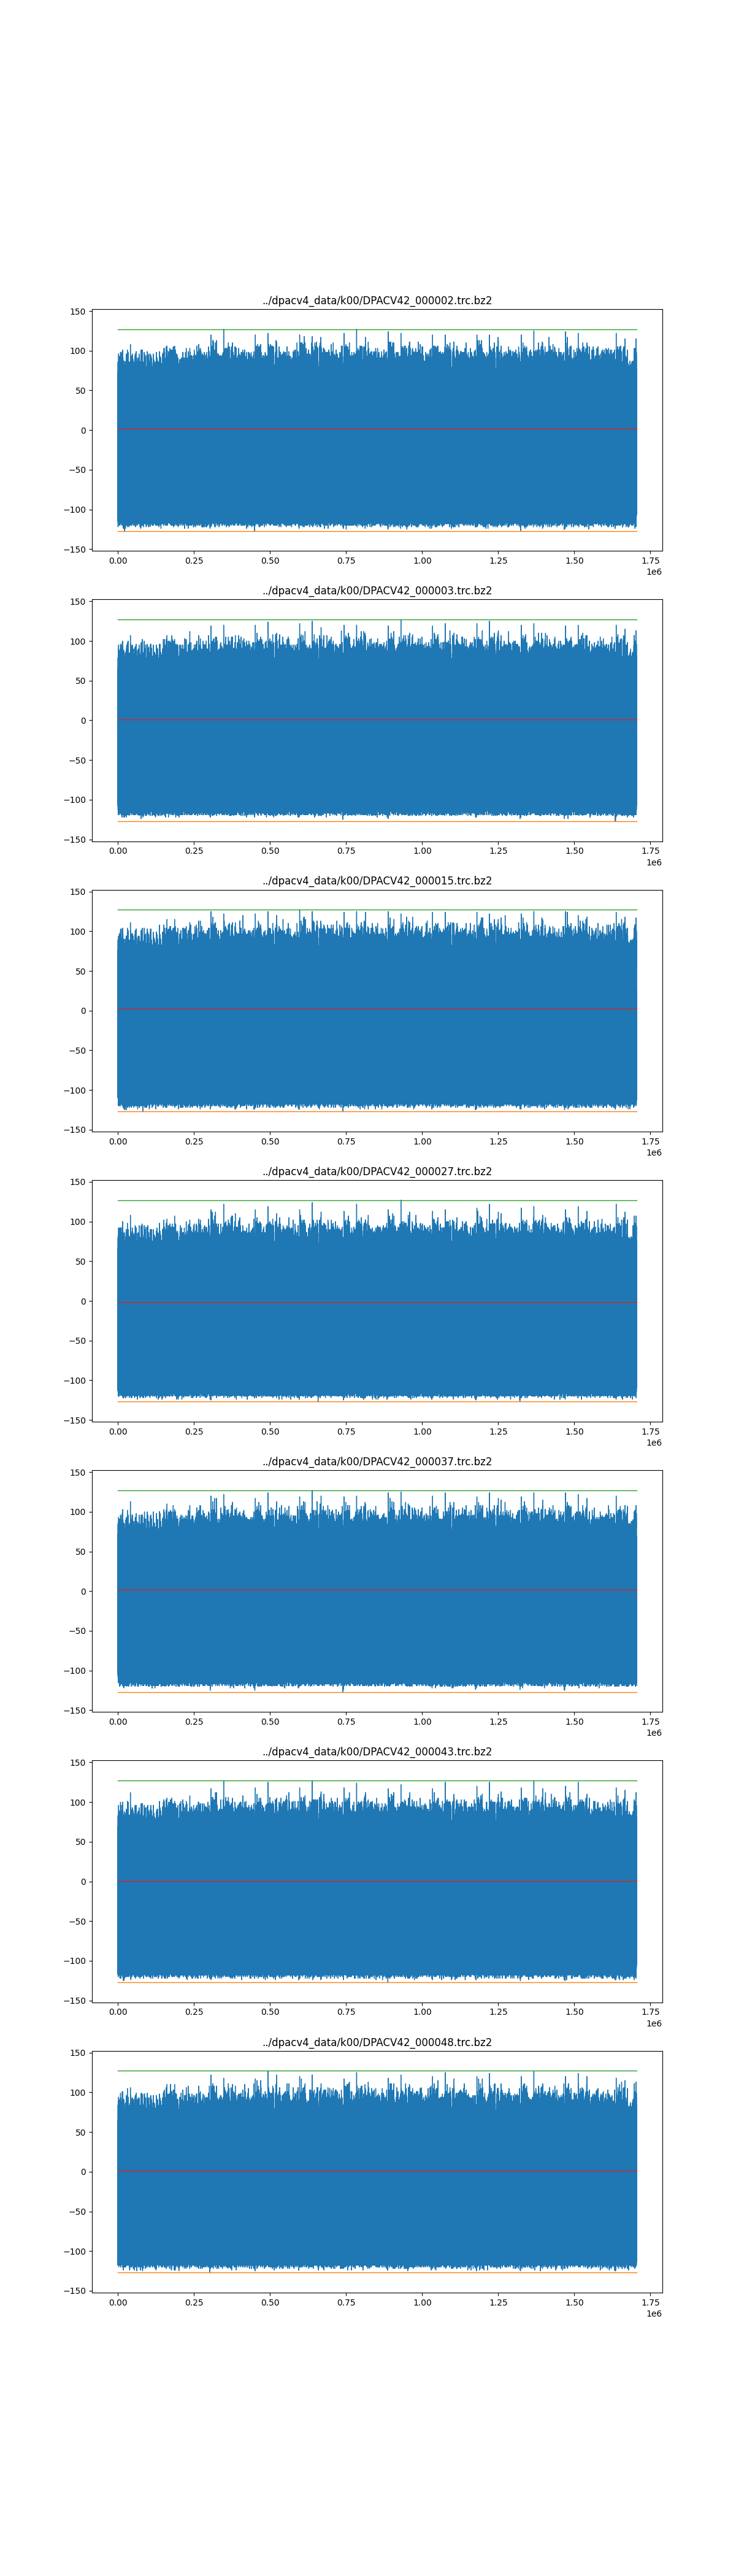

In [8]:
%matplotlib notebook 

from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6 * len(trace_data)), dpi=80)
subplot_id = 1

ymin = None
ymax = None
for data in trace_data:
    a =  numpy.min(data[TRACE])
    b =  numpy.max(data[TRACE])
    if (ymin == None) or (ymin < a):
        ymin = a
    if (ymax == None) or (ymax > b):
        ymax = b
d = numpy.abs(ymin - ymax) / 10
ymin = ymin - d
ymax = ymax + d

for data in trace_data:
    plt.subplot(len(trace_data) * 100 + 10 + subplot_id)
    plt.plot(range(len(data[TRACE])), data[TRACE], linewidth=1)
    plt.plot([0, len(data[TRACE])], [numpy.min(data[TRACE]), numpy.min(data[TRACE])], linewidth=1)
    plt.plot([0, len(data[TRACE])], [numpy.max(data[TRACE]), numpy.max(data[TRACE])], linewidth=1)
    plt.plot([0, len(data[TRACE])], [numpy.average(data[TRACE]), numpy.average(data[TRACE])], linewidth=1)
    plt.ylim(ymin=ymin, ymax=ymax)
    plt.title(data[FILENAME])
    #plt.scatter(range(len(draw_trace)), draw_trace, s=1)
    # for the next subplot
    subplot_id = subplot_id + 1
plt.show()

### Visualizations in Fourier space
We visualize the complete sequence of data first

In [9]:
FOURIER = 'fourier'
for data in trace_data:
    # run ifftshift for positioning the time zero for the first element
    data[FOURIER] = numpy.fft.fft(numpy.fft.ifftshift(data[TRACE]))
    pprint.pprint(data[FOURIER].shape)


(1704402,)
(1704402,)
(1704402,)
(1704402,)
(1704402,)
(1704402,)
(1704402,)


<IPython.core.display.Javascript object>


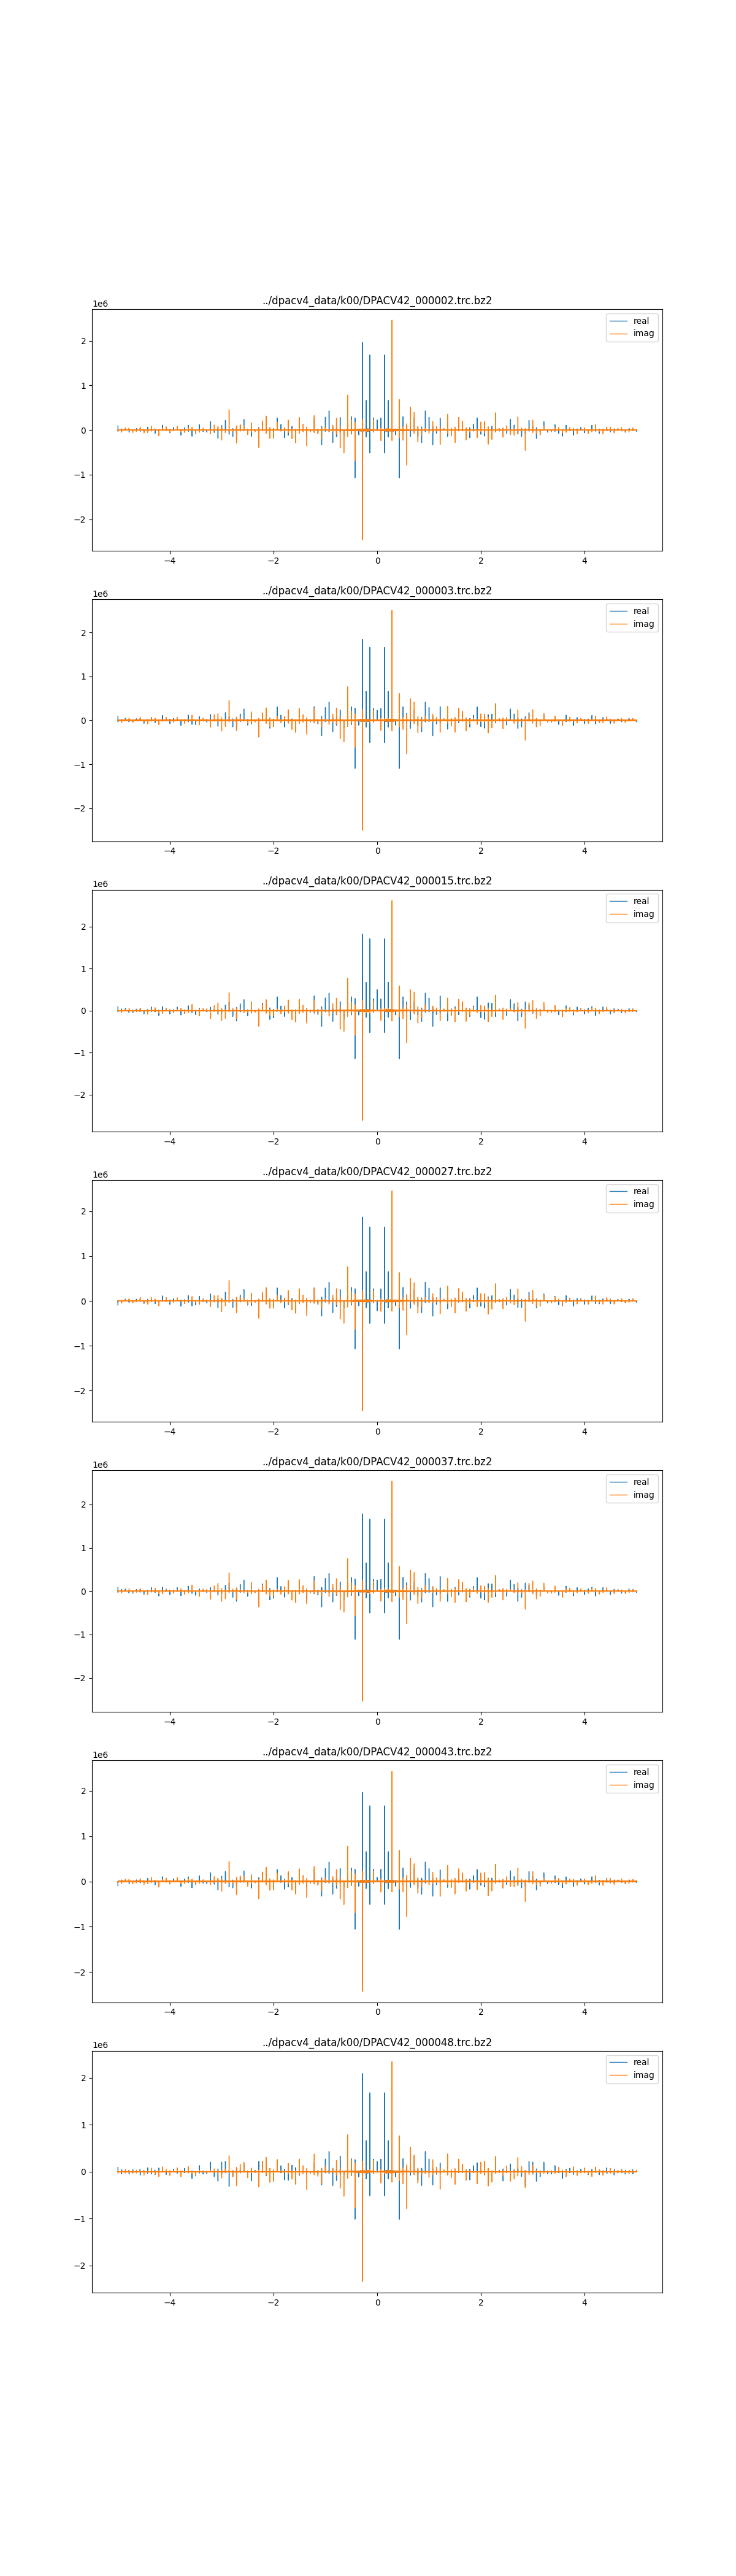

In [10]:
dt = 0.1

plt.figure(figsize=(12, 6 * len(trace_data)), dpi=80)
subplot_id = 1
for data in trace_data:
    plt.subplot(len(trace_data) * 100 + 10 + subplot_id)   
    # calculate frequencies fftfreq
    freq = numpy.fft.fftfreq(len(data[TRACE]), d=dt)
    x = numpy.fft.fftshift(freq)
    # run fftshift for positioning the frequency zero in center
    y = dt * numpy.fft.fftshift(data[FOURIER])
    
    plt.plot(x, y.real, linewidth=1, label='real')
    plt.plot(x, y.imag, linewidth=1, label='imag')
    plt.title(data[FILENAME])
    plt.legend()

    subplot_id = subplot_id + 1
plt.show()    

In [11]:
# compute FFT with windows, the number of windows is len(data) / (nperseg/2) when noverlap is None

from scipy import signal


nperseg = 128  # Length of each segment
fs = 1e6 # Sampling frequency of the trace (I don't know this value)
WINDOW_FOURIER = 'window fourier'
for data in trace_data:
    d = data[TRACE]
    f, t, Zxx = signal.stft(d, fs, nperseg=nperseg, axis=0)
    pprint.pprint('%s, %s %s' % (f.shape, t.shape, Zxx.shape))
    averages = []
    mins = []
    maxs = []
    for r in  t:
        idx = int(r * fs)
        if (idx < len(d)):
            averages.append(numpy.average(d[idx: idx + nperseg]))
            mins.append(numpy.min(d[idx: idx + nperseg]))
            maxs.append(numpy.max(d[idx: idx + nperseg]))
    data[WINDOW_FOURIER] = (f, t, Zxx, averages, mins, maxs)

'(65,), (26633,) (65, 26633)'
'(65,), (26633,) (65, 26633)'
'(65,), (26633,) (65, 26633)'
'(65,), (26633,) (65, 26633)'
'(65,), (26633,) (65, 26633)'
'(65,), (26633,) (65, 26633)'
'(65,), (26633,) (65, 26633)'


<IPython.core.display.Javascript object>


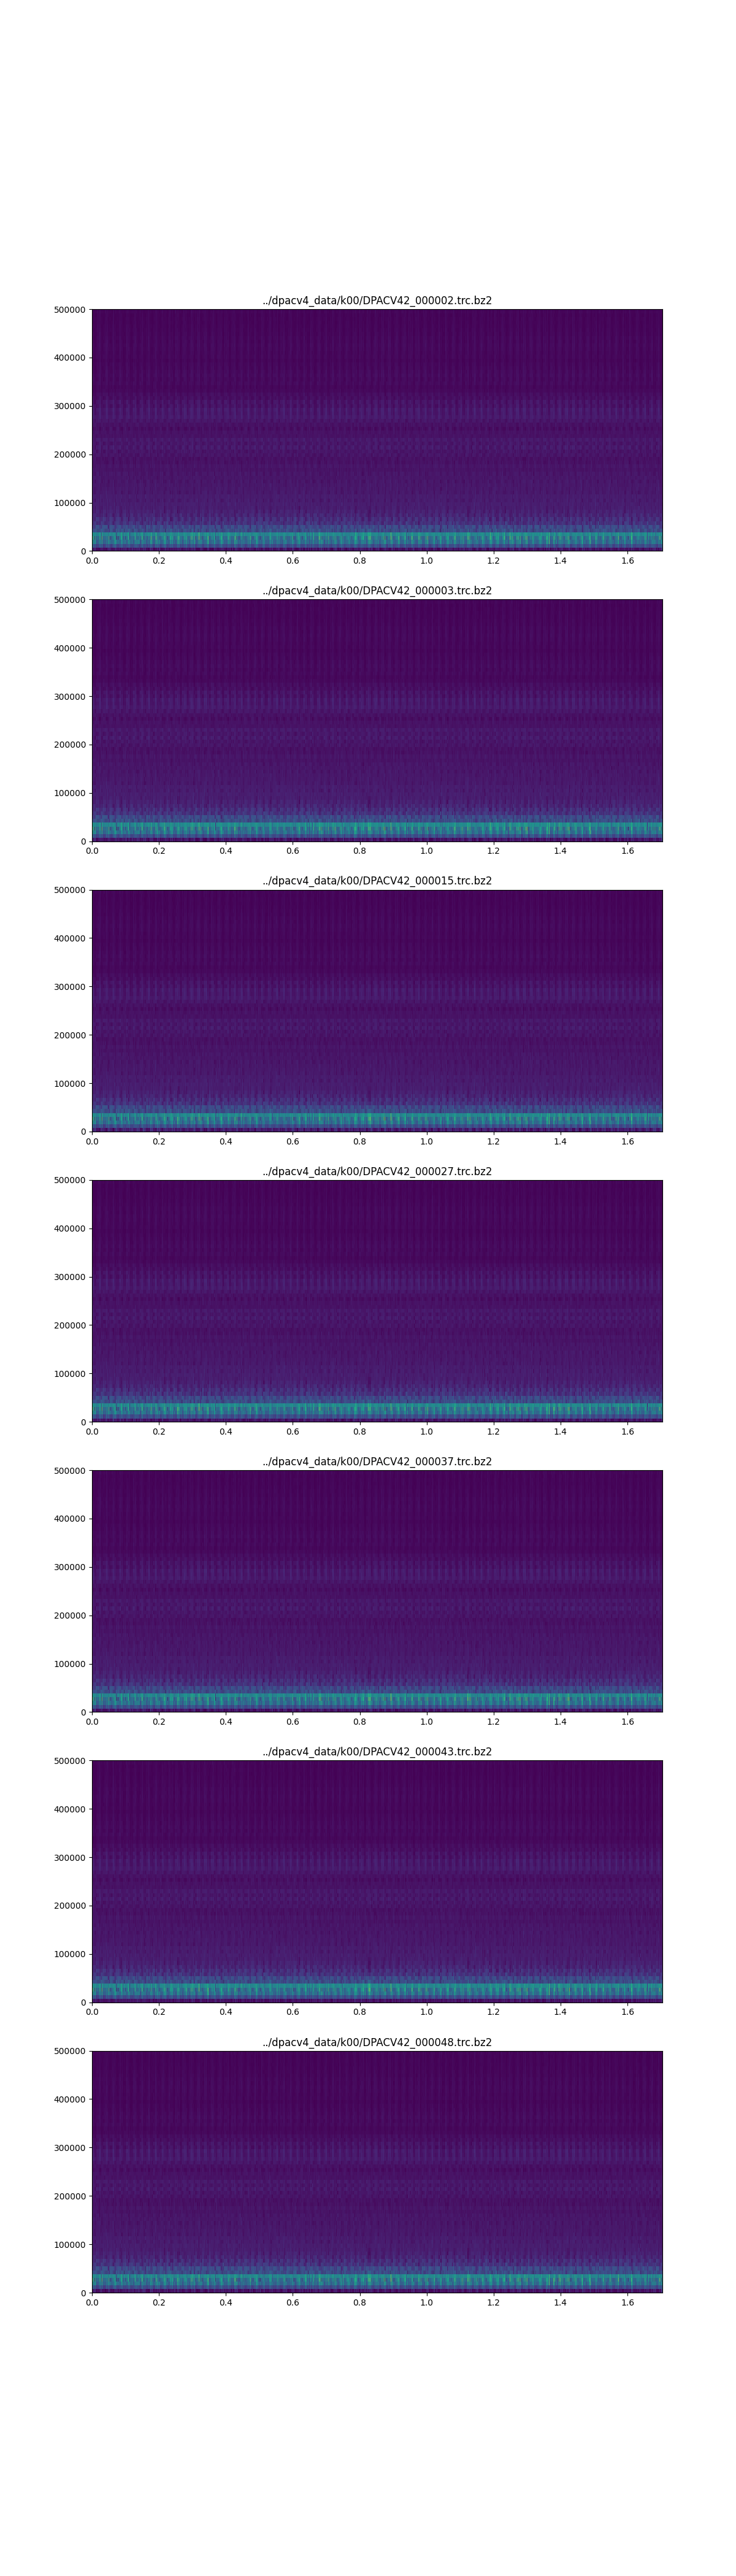

In [12]:
plt.figure(figsize=(12, 6 * len(trace_data)), dpi=80)
subplot_id = 1
for data in trace_data:
    plt.subplot(len(trace_data) * 100 + 10 + subplot_id)
    f, t, Zxx, _, _, _ = data[WINDOW_FOURIER]
    plt.pcolormesh(t, f, numpy.abs(Zxx))
    plt.title(data[FILENAME])
    #plt.scatter(range(len(draw_trace)), draw_trace, s=1)
    # for the next subplot
    subplot_id = subplot_id + 1
plt.show()

<IPython.core.display.Javascript object>


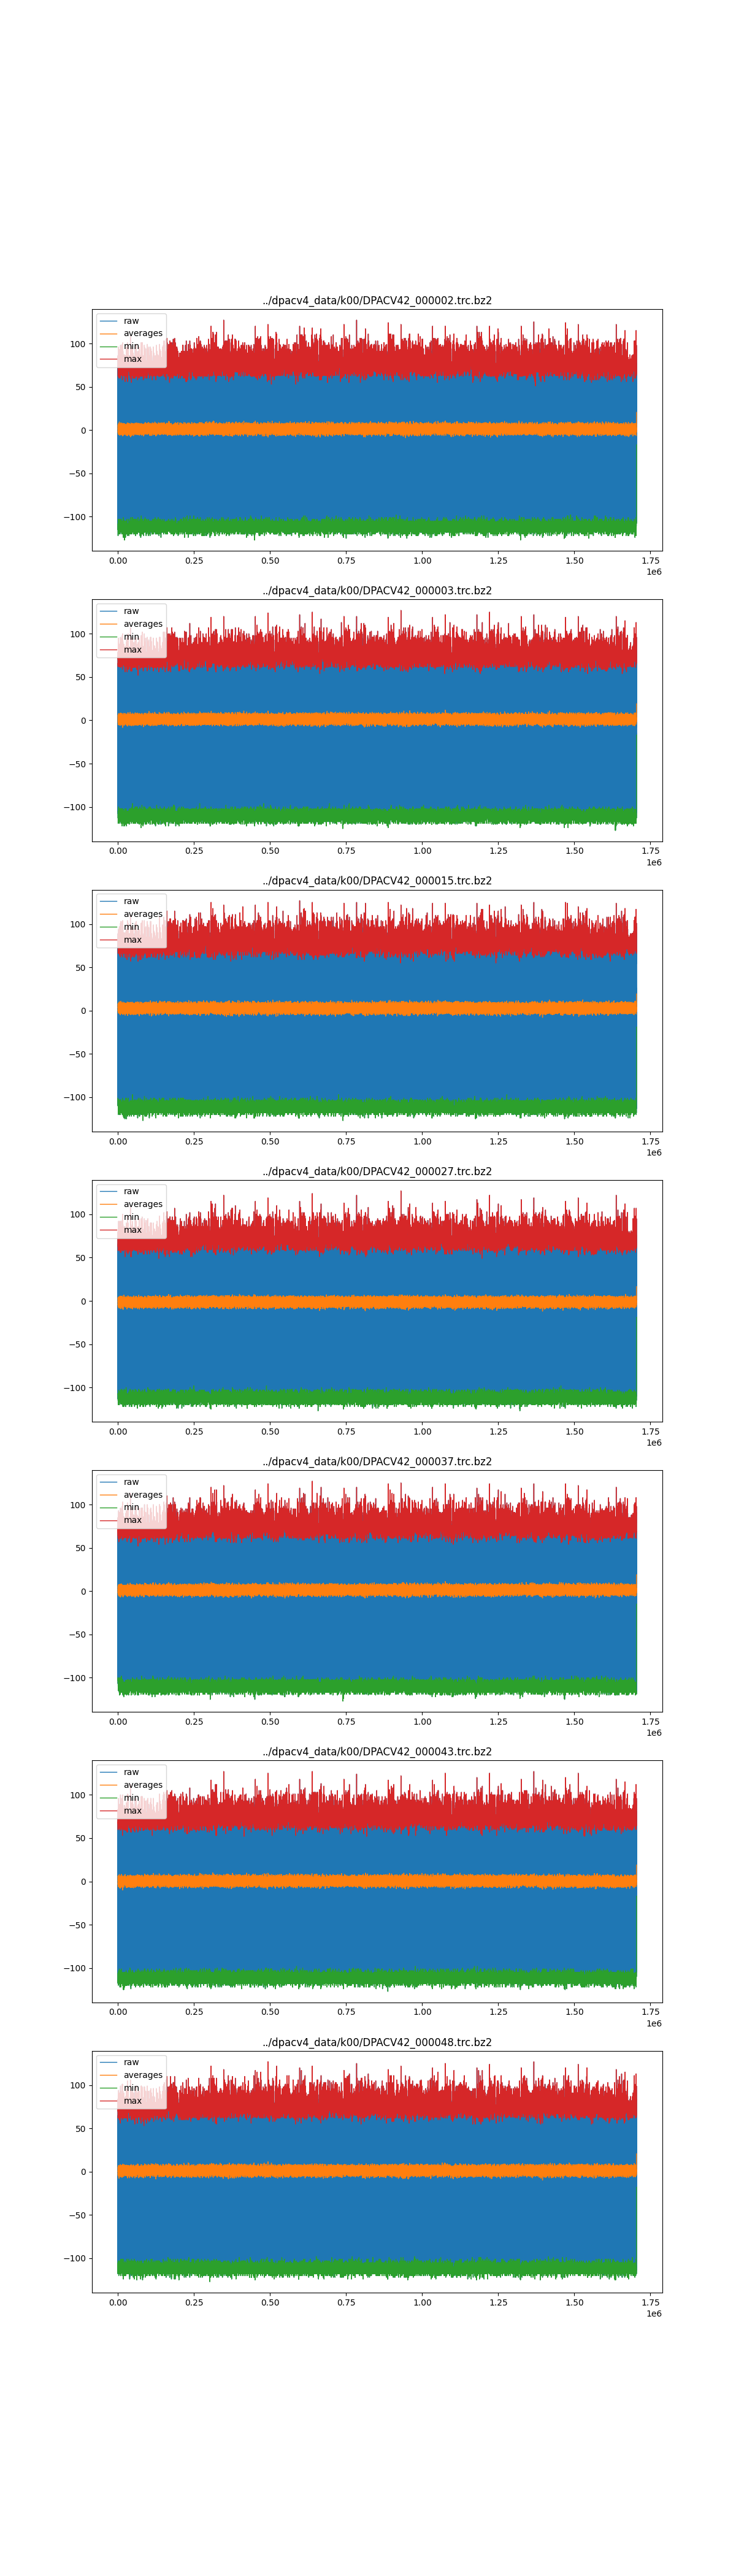

In [13]:
plt.figure(figsize=(12, 6 * len(trace_data)), dpi=80)
subplot_id = 1

for data in trace_data:
    plt.subplot(len(trace_data) * 100 + 10 + subplot_id)
    plt.plot(range(len(data[TRACE])), data[TRACE], linewidth=1, label='raw')
    _, _, _, averages, mins, maxs = data[WINDOW_FOURIER]
    plt.plot(range(len(data[TRACE])), numpy.repeat(averages, nperseg/2)[:len(data[TRACE])], linewidth=1, label='averages')
    plt.plot(range(len(data[TRACE])), numpy.repeat(mins, nperseg/2)[:len(data[TRACE])], linewidth=1, label='min')   
    plt.plot(range(len(data[TRACE])), numpy.repeat(maxs, nperseg/2)[:len(data[TRACE])], linewidth=1, label='max')
    plt.title(data[FILENAME])
    plt.legend()
    #plt.scatter(range(len(draw_trace)), draw_trace, s=1)
    # for the next subplot
    subplot_id = subplot_id + 1
plt.show()

In [14]:
df_traces = pandas.DataFrame()
for data in trace_data:
    df_traces[os.path.basename(data[FILENAME])] = data[TRACE]

In [15]:
df_traces.corr(method='pearson')

,DPACV42_000002.trc.bz2,DPACV42_000003.trc.bz2,DPACV42_000015.trc.bz2,DPACV42_000027.trc.bz2,DPACV42_000037.trc.bz2,DPACV42_000043.trc.bz2,DPACV42_000048.trc.bz2
DPACV42_000002.trc.bz2,1.000000,0.984112,0.971210,0.988990,0.973157,0.991033,0.977242
DPACV42_000003.trc.bz2,0.984112,1.000000,0.988137,0.990254,0.988708,0.981149,0.951658
DPACV42_000015.trc.bz2,0.971210,0.988137,1.000000,0.982553,0.991864,0.966831,0.929595
DPACV42_000027.trc.bz2,0.988990,0.990254,0.982553,1.000000,0.983634,0.987260,0.963120
DPACV42_000037.trc.bz2,0.973157,0.988708,0.991864,0.983634,1.000000,0.968478,0.932091
DPACV42_000043.trc.bz2,0.991033,0.981149,0.966831,0.987260,0.968478,1.000000,0.980196
DPACV42_000048.trc.bz2,0.977242,0.951658,0.929595,0.963120,0.932091,0.980196,1.000000
